In [2]:
!python -m pip install --upgrade pip
!pip install tqdm

In [3]:
import tqdm
from concurrent.futures import ProcessPoolExecutor

# Performance Visualization of Jakobsen's Algorithm

## Setting Paramaters and Getting Plaintext

In [4]:
# Common Values
wordLengths = [10, 15, 20, 25, 50, 75, 100, 200, 300, 400, 500]
numberOfTrials = 100

In [5]:
from src.utils.utils import selectPlainText

def getPlaintextSamples(length, numberOfSamples):

    plaintextSamples = []

    for _ in range(numberOfSamples):
        plaintextSamples.append(selectPlainText(length))
    
    return plaintextSamples

plaintextSamples = {}
for length in wordLengths:
    print("Getting plaintext samples of length", length, end = '\r')
    plaintextSamples[length] = getPlaintextSamples(length, numberOfTrials)

print(str(numberOfTrials) +" plaintext samples gathered for lengths", ", ".join([str(word) for word in wordLengths]))

100 plaintext samples gathered for lengths 10, 15, 20, 25, 50, 75, 100, 200, 300, 400, 500


## Computing Data

In [6]:
# Helper function to get results
def getResults(decryptionFunction, plaintextTests, spacesRemoved, max_workers=12):

    # Getting results of Jakobsen's with spaced queries
    results = {}
    executor = ProcessPoolExecutor(max_workers=max_workers)

    for length, plaintextList in plaintextTests.items():
        jobQueue = []
        results[length] = []

        for plaintext in plaintextList:
            jobQueue.append(executor.submit(decryptionFunction, plaintext, length, spacesRemoved))

        for future in tqdm.tqdm(jobQueue, desc="Processing trials of length " + str(length)):
            results[length].append(future.result())

    executor.shutdown()
    return results

In [7]:
# Getting results of standard jakobsensAlgorithm on spaced plaintexts
from src.jakobsensAlgorithm import testJakobsens
resultsSpacedJakobsens = getResults(testJakobsens, plaintextSamples, False, max_workers=12)

Processing trials of length 10:   0%|          | 0/100 [00:00<?, ?it/s]

Processing trials of length 500: 100%|██████████| 100/100 [00:10<00:00,  9.23it/s]


In [8]:
print(resultsSpacedJakobsens[500][:10])

[(26, 1.0), (26, 1.0), (26, 1.0), (26, 1.0), (26, 1.0), (23, 0.9995460735360872), (26, 1.0), (26, 1.0), (26, 1.0), (26, 1.0)]


In [9]:
resultsUnspacedJakobsens = getResults(testJakobsens, plaintextSamples, True, max_workers=12)

Processing trials of length 10:   0%|          | 0/100 [00:00<?, ?it/s]

Processing trials of length 500: 100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


In [10]:
# Helper function to get results
def getResultsRandomRestart(decryptionFunction, plaintextTests, numRestarts, spacesRemoved, max_workers=12):

    # Getting results of Jakobsen's with spaced queries
    results = {}
    executor = ProcessPoolExecutor(max_workers=max_workers)

    for length, plaintextList in plaintextTests.items():
        jobQueue = []
        results[length] = []

        for plaintext in plaintextList:
            jobQueue.append(executor.submit(decryptionFunction, plaintext, length, numRestarts=numRestarts, spacesRemoved=spacesRemoved))

        for future in tqdm.tqdm(jobQueue, desc="Processing trials of length " + str(length)):
            results[length].append(future.result())

    executor.shutdown()
    return results

In [11]:
from src.jakobsensAlgorithmRandomStart import testJakobsensRandomRestart

# Getting results of standard jakobsensAlgorithm on unspaced plaintexts
#print(plaintextSamples[10][0])
#print(testJakobsensRandomRestart(plaintextSamples[10][0], 10))
resultsUnspacedJakobsensRandomRestart = getResultsRandomRestart(testJakobsensRandomRestart, plaintextSamples, 5, True, max_workers=30)

Processing trials of length 500: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


In [12]:
resultsSpacedJakobsensRandomRestart = getResultsRandomRestart(testJakobsensRandomRestart, plaintextSamples, 5, False, max_workers=60)

Processing trials of length 500: 100%|██████████| 100/100 [00:44<00:00,  2.22it/s]


In [13]:
#from src.jakobsensAlgorithmRandomStart import testJakobsensRandomRestartCheating
#resultsSpacedCheating = getResultsRandomRestart(testJakobsensRandomRestartCheating, plaintextSamples, 5, False, max_workers=30)

## Formatting and Aggregating Results 

In [14]:
def formatResults(resultsDictionary):

    formattedResultsDictionary = {}
    for length, results in resultsDictionary.items():
        letterResults = [lettersFound for lettersFound, _ in results]
        percentResults = [percentDecoded for _, percentDecoded in results]
        formattedResultsDictionary[length] = (sum(letterResults)/len(letterResults), sum(percentResults)/len(percentResults))
    
    return formattedResultsDictionary

In [15]:
formattedResultsSpacedJakobsens = formatResults(resultsSpacedJakobsens)
formattedResultsUnspacedJakobsens = formatResults(resultsUnspacedJakobsens)
formattedResultsSpacedJakobsensRandomRestart = formatResults(resultsSpacedJakobsensRandomRestart)
formattedResultsUnspacedJakobsensRandomRestart = formatResults(resultsUnspacedJakobsensRandomRestart)

## Visualizations

In [16]:
# TODO: Create a function to make boxplots

In [17]:
resultsDictionaries = [formattedResultsSpacedJakobsens, formattedResultsUnspacedJakobsens, formattedResultsSpacedJakobsensRandomRestart, formattedResultsUnspacedJakobsensRandomRestart]
resultsLabels = ["Spaced Jakobsens", "Spaceless Jakobsons", "Spaced Random Restart", "Spaceless Random Restart"]
resultsLettersSolved = []
resultsPercentSolved = []

for resultsDict in resultsDictionaries:
    lettersSolved = []
    percentSolved = []
    for length, results in resultsDict.items():
        lettersSolved.append(results[0])
        percentSolved.append(results[1])
    resultsLettersSolved.append(lettersSolved)
    resultsPercentSolved.append(percentSolved)

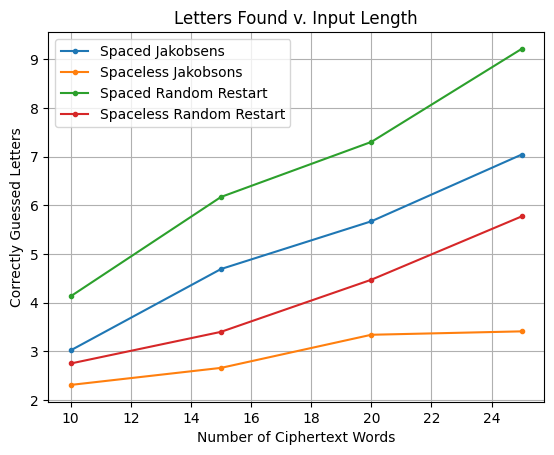

In [36]:
import matplotlib.pyplot as plt

def graphLettersSolved(wordLengths, lettersFound, lettersFoundLabels): #letters, letters_spaced):

    for i in range(len(lettersFound)):
        plt.plot(wordLengths[:4], lettersFound[i][:4], marker = ".", linestyle = "-", label = lettersFoundLabels[i])
    plt.xlabel('Number of Ciphertext Words')
    plt.ylabel('Correctly Guessed Letters')
    plt.title('Letters Found v. Input Length')
    plt.grid(True)
    plt.legend()
    plt.show()

graphLettersSolved(wordLengths, resultsLettersSolved, resultsLabels)

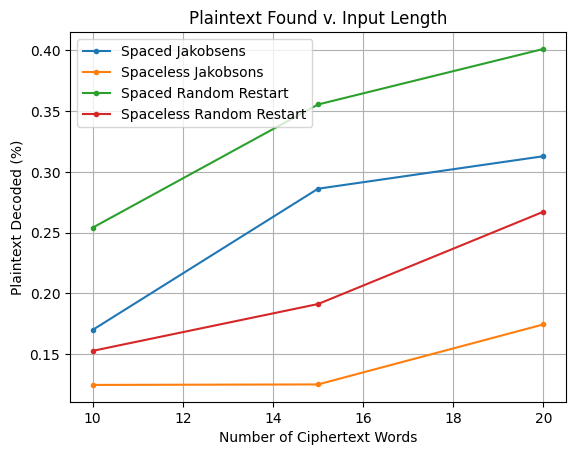

In [34]:
import matplotlib.pyplot as plt

def graphPlaintextSolved(wordLengths, plaintextFound, plaintextFoundLabels): #letters, letters_spaced):

    for i in range(len(plaintextFound)):
        plt.plot(wordLengths[:3], plaintextFound[i][:3], marker = ".", linestyle='-', label = plaintextFoundLabels[i])
    plt.xlabel('Number of Ciphertext Words')
    plt.ylabel('Plaintext Decoded (%)')
    plt.title('Plaintext Found v. Input Length')
    plt.grid(True)
    plt.legend()
    plt.show()
graphPlaintextSolved(wordLengths, resultsPercentSolved, resultsLabels)

## Returns Gained from Increasing the Number of Restarts

In [20]:
restartWordLengths = [10, 15, 20, 25, 50, 75, 100]
restartNumberOfTrials = 60


restartPlaintextSamples = {}
for length in restartWordLengths:
    print("Getting plaintext samples of length", length, end = '\r')
    restartPlaintextSamples[length] = getPlaintextSamples(length, restartNumberOfTrials)

print(str(restartNumberOfTrials) +" plaintext samples gathered for lengths", ", ".join([str(word) for word in restartWordLengths]))

60 plaintext samples gathered for lengths 10, 15, 20, 25, 50, 75, 100


In [21]:
numberOfRestarts = [1, 3, 5, 10, 15]

restartTrialSpacedResults = {}

for numRestarts in numberOfRestarts:
    restartTrialSpacedResults[numRestarts] = getResultsRandomRestart(testJakobsensRandomRestart, restartPlaintextSamples, numRestarts, False, max_workers=60)

Processing trials of length 100: 100%|██████████| 60/60 [01:16<00:00,  1.27s/it] 


In [24]:
formattedSpacedRestartTrialResults = {}
for numRestarts, results in restartTrialSpacedResults.items():
    formattedSpacedRestartTrialResults[numRestarts] = formatResults(results)

[[0.18422298541324306, 0.21314485269188257, 0.31508133802118105, 0.38636231626165024, 0.6545777254441053, 0.8265936778467895, 0.8678084411771823], [0.2045271391978914, 0.2852553810358118, 0.4056657896059444, 0.4697948757111752, 0.796280044571183, 0.9158061541670007, 0.9655341484724433], [0.2466603571640605, 0.41086565025615923, 0.3999648351345415, 0.5518786815242213, 0.8115726532346142, 0.9096958210047268, 0.9621538470359973], [0.30521388876979155, 0.437253090160412, 0.4840115925179069, 0.6056759754900666, 0.8465931315850121, 0.906645385279318, 0.9670055935592773], [0.3333134558316677, 0.4283138686329884, 0.4932236297040655, 0.6345260723452764, 0.8193311280178348, 0.8961479030921108, 0.9702678531569203]]


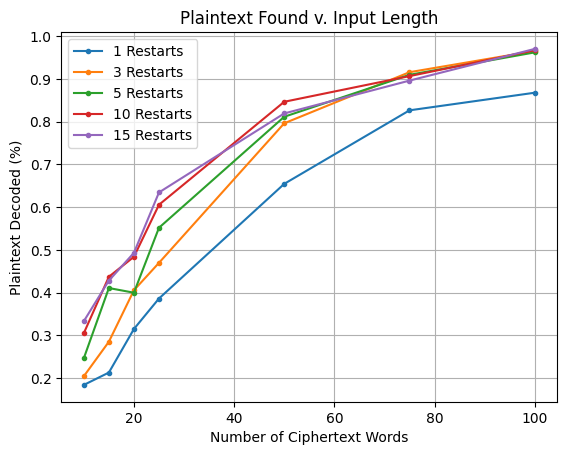

In [31]:
restartLabels = []
restartPlaintextSolved = []
restartLettersSolved = []

for numRestarts, resultDict in formattedSpacedRestartTrialResults.items():
    restartLabels.append(str(numRestarts) + " Restarts")
    lettersSolved = []
    percentSolved = []
    for length, results in resultDict.items():
        lettersSolved.append(results[0])
        percentSolved.append(results[1])
    restartLettersSolved.append(lettersSolved)
    restartPlaintextSolved.append(percentSolved)


print(restartPlaintextSolved)
graphPlaintextSolved(restartWordLengths, restartPlaintextSolved, restartLabels)


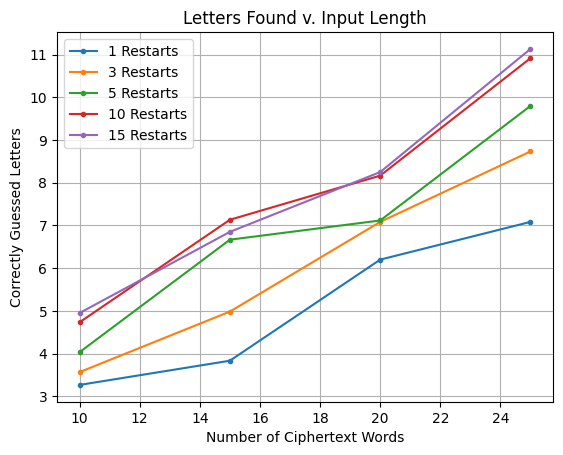

In [38]:
graphLettersSolved(restartWordLengths, restartLettersSolved, restartLabels)